“If the spectral floor parameter β is too large, then the residual noise will be audible but the musical noise will not be perceptible. Conversely, if β is too small, the musical noise will become annoying but the residual noise will be markedly reduced.” ([Loizou, p. 108](zotero://select/library/items/IBKAK3L2)) ([pdf](zotero://open-pdf/library/items/YVIX94UY?page=136&annotation=XLWMHG3L))

in this case floor param beta is db_reduc

“This then suggests that spectral flooring occurs more often when α is large compared to when α is small.” ([Loizou, p. 111](zotero://select/library/items/IBKAK3L2)) ([pdf](zotero://open-pdf/library/items/YVIX94UY?page=139&annotation=UQE9L277))

“It is extremely difficult to minimize musical noise without affecting the speech signal itself in some way, and, in general, there is a trade-off between the amount of noise reduction and speech distortion introduced” ([Loizou, p. 107](zotero://select/library/items/IBKAK3L2)) ([pdf](zotero://open-pdf/library/items/YVIX94UY?page=135&annotation=L5H3TZQ3))




In [4]:
import numpy as np
class SpecSub(object):
    """
    Parameters
    ----------
    nfft: int
        FFT frame size. used to determine the number of frequency bins.
    db_reduc: float
        Maximum reduction in dB for each bin.
    lookback: int
        How many frames to look back for the noise estimate.
    alpha: float
        Overestimation factor to "push" the gain filter value (at each
        frequency) closer to the dB reduction specified by ``db_reduc``.
        Oversubtraction factor
    gamma: float, optional
        Exponent factor to modify transition behavior towards the dB reduction 
        specified by ``db_reduc``. Default is 1.
    """

    def __init__(self, nfft, db_reduc, lookback, alpha, gamma=1):

        self.alpha = alpha
        self.gamma = gamma

        self.n_bins = nfft//2+1
        self.previous_noise_estimate = np.zeros((self.n_bins, lookback+1))
        self.min_gain = 10**(-db_reduc/20)
        # print('min_gain', self.min_gain)
        self.signal_power = np.zeros(self.n_bins)
        self.current_noise_power = np.zeros(self.n_bins)

    def calculate_filter(self, X):
        """
        Parameters
        ----------
        X: Complex ndarray of length ``nfft//2+1``.
        Single time frame of STFT.
        
        Returns
        -------
        floating point ndarray
            Gain filter to multiply given spectrum with.
        """

        # calculate power of the noised
        self.signal_power[:] = abs(X)**2

        # estimate noise power for each frequency bin
        self.previous_noise_estimate[:, -1] = self.signal_power
        self.current_noise_power[:] = np.min(self.previous_noise_estimate, axis=1)

        # compute gain filter
        # computed_gain = ((self.signal_power - self.alpha*self.current_noise_power)/self.signal_power)**self.gamma
        comp_gain = [(max(self.signal_power[k]-self.alpha*self.current_noise_power[k], 0) / self.signal_power[k])**self.gamma for k in range(self.n_bins)]
        gain_filter = np.minimum(comp_gain, self.min_gain)
        

        # update
        self.previous_noise_estimate = np.roll(self.previous_noise_estimate, -1, axis=1)

        return gain_filter

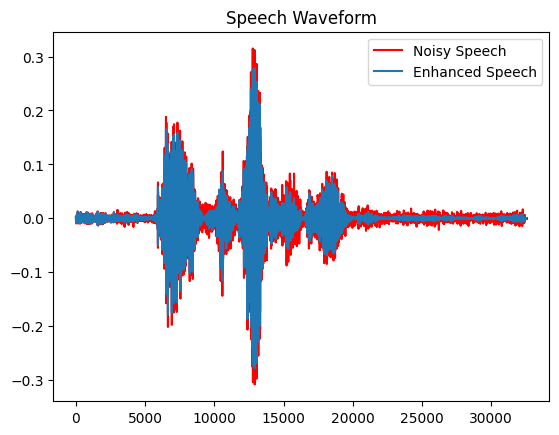

In [6]:

import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
testfile ="C:\\Users\\Julio\\Documents\\Projects\\audio-denoiser\\data\\test.wav"
x, sr = librosa.load(testfile, sr=16000)
n_fft = 512
hop = int(.5*n_fft)
X = librosa.stft(x, n_fft=n_fft, hop_length=hop)
ss = SpecSub(n_fft, db_reduc=1, lookback=12, alpha=30, gamma=.5)
processed_audio = np.zeros(x.shape)
n = 0
clean_signal_stft = []
# frame wise stft
for n in range(X.shape[1]):
    gain = ss.calculate_filter(X[:, n])
    # back to time domain
    clean_signal_stft.append(gain * X[:, n])

# fix orientation of stft
clean_signal_stft = np.array(clean_signal_stft).T
# clean_signal_stft = np.maximum(clean_signal_stft, 0)

clean_signal = librosa.istft(clean_signal_stft,n_fft=n_fft, hop_length=hop)
plt.plot(x, 'red')
plt.plot(clean_signal)
plt.title('Speech Waveform')
plt.legend(['Noisy Speech', 'Enhanced Speech'])

In [ ]:
def apply_spectral_sub(noisy_signal, nfft=512, db_reduc=25, lookback=12,
                       beta=30, alpha=1):

    from pyroomacoustics import hann
    from pyroomacoustics.transform import STFT

    hop = nfft // 2
    window = hann(nfft, flag='asymmetric', length='full')
    stft = STFT(nfft, hop=hop, analysis_window=window, streaming=True)
    scnr = ss

    processed_audio = np.zeros(noisy_signal.shape)
    n = 0
    while noisy_signal.shape[0] - n >= hop:
        # SCNR in frequency domain
        stft.analysis(noisy_signal[n:(n + hop), ])
        gain_filt = scnr.calculate_filter(stft.X)

        # back to time domain
        processed_audio[n:n + hop, ] = stft.synthesis(gain_filt * stft.X)

        # update step
        n += hop

    return processed_audio
ipd.Audio(apply_spectral_sub(x), rate=sr)

In [7]:
ipd.Audio(x, rate=sr)

In [8]:
ipd.Audio(clean_signal, rate=sr)